This notebook is for creating the data, that is needed to do spatio-temporal correlation plots. This is NOT the notebook where these plots are mainly made. 

In [1]:
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import xarray as xr
import atlite
import logging
import cdsapi
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
from cartopy.io import shapereader
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd

import pgeocode      
import seaborn as sns         

import scipy.sparse as sp
from collections import OrderedDict
%matplotlib inline
import requests
import os
os.environ['ESGF_PYCLIENT_NO_FACETS_STAR_WARNING']='1'
import zipfile

from matplotlib.gridspec import GridSpec
from atlite.gis import shape_availability, ExclusionContainer
# from rasterio.plot import show
import rasterio

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import datetime
import glob

from sklearn.metrics import mean_squared_error
import math
from pathlib import Path

# Defining figure size for maps:
map_fig_size = (10,10)

In [2]:
from countrygroups import EUROPEAN_UNION

# Adding non-EU countries to the list of countries
#others = (["Switzerland","Czech Republic", "Ukraine","Moldova", "Serbia","Albania", "United Kingdom", 
#           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
others = (["Switzerland","Czech Republic", "Serbia","Albania", "United Kingdom", 
           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
europe_list = EUROPEAN_UNION.names + others
europe_list.remove("Czechia")
europe_list.sort()
# print(europe_list)

c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


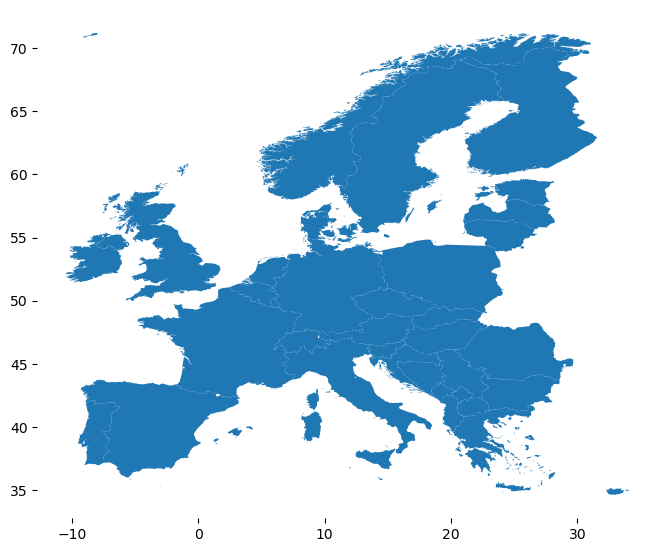

In [3]:
# Defining shape of European countries

shpfilename = shapereader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shapereader.Reader(shpfilename)
Europe = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
#).reindex(["Austria","Denmark","Germany","Italy"])
).reindex(europe_list)

# Removing extra territories (islands in the Atlantic, etc.)
mask = (-11, 30, 50, 74)
Europe = Europe.clip(mask)
Europe.plot(figsize=(8,8),aspect='equal').set_frame_on(False)

In [4]:
bounds = Europe.unary_union.buffer(1).bounds
model_colors = pd.read_excel("model_colors.xlsx",header=0,index_col=0)

In [5]:
# All CMIP6 models: 
CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'AWI-CM-1-1-MR']
CMIP6_models_wind = ['EC-Earth3','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','EC-Earth3-Veg'] #wind
CMIP6_models_solar = ['EC-Earth3', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','ACCESS-CM2']
ssp_variants = ['ssp585']

## Defining cutouts 

In [6]:
# Importing/creating  CMIP6 cutouts from external HDD
# Models with all 4 ssp variants:
CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR','MPI-ESM1-2-HR','HadGEM3-GC31-LL','HadGEM3-GC31-MM','ACCESS_CM2','AWI-CM-1-1-MR','EC-Earth3-Veg','IPSL-CM6A-LR']
ssp_variants = ['ssp585']

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        cutout_name = f'Europe_{i}_{j}_{yy_start}_{yy_end}'
        filename = f'Europe_{i}_{j}_{yy_start}_{yy_end}.nc'
        path = f"E://Master's/CMIP6_BOC/{filename}"
        locals()[cutout_name] = atlite.Cutout(
        path=path, module="cmip", bounds=bounds, time=slice(start_date, end_date),
        dt='3H',dx=1, dy=1)

c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already 

In [7]:
path = "E://Master's/ERA5/"
ERA5_filepaths = glob.glob(path+'*.nc')

# NB time argument is ignored, so will not be specified properly. 
path = "E://Master's/ERA5\\"

for filename in ERA5_filepaths:
    cutout_name = filename.replace('.nc','').replace(path,'')
    locals()[cutout_name] = atlite.Cutout(
        path=filename, module="era5", bounds=bounds, time=slice(start_date, end_date),
        dt='3H',dx=1, dy=1)

c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already 

# Please note: 
In order to do the spatio-temporal correlation analysis, all values are needed, also for places in the cutout which is over ocean. These are have been removed from the data typically used, as the thesis focuses on on-land energy sources. Therefore, the corrected wind- and influx values have had to be recalculated for this part. After it was recalculated, it has been saved as a .nc file. Therefore, the cells below are only run once, whereafter the .nc files are loaded into the program instead of always doing the same calculation. This calculation takes quite a while.

When this programme has been run, it has been run from the "Retrieving the data which is saved as an .nc file" cell further down in the document.

## Loading data before corrections

In [8]:
# ## Calculation of wind speed at 90 m for ERA5

# # Calculating wind speed at hub height for ERA5 (as a timeseries for every cutout)
# for i in range(15,23):
#     cutout_name = f'Europe_era5_{i}'
#     # Calculating wind speed at hub height: 
#     from_height = 100;
#     from_name = "wnd{h:0d}m".format(h=int(from_height));
#     # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#     to_height = 90
#     to_name = "wnd{h:0d}m".format(h=int(to_height));
#     to_cutout_name = f'{cutout_name}_{to_name}'
#     ds = locals()[cutout_name].data

#     locals()[to_cutout_name] = ds[from_name] * (
#                 np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"])
#             )
#     locals()[to_cutout_name].attrs.update({"long name": "Extrapolated {ht} m wind speed using logarithmic "
#                         "method with roughness and {hf} m wind speed"
#                         "".format(ht=to_height, hf=from_height),
#                         "units": "m s**-1"})
    
# # Combining all years into 1 file: "ERA5_wnd90m"
# cutout_name = f'Europe_era5_15_wnd90m'
# era5_wnd90m = xr.DataArray(locals()[cutout_name])
# for i in range(16,23):
#     cutout_name = f'Europe_era5_{i}_wnd90m'
#     era5_wnd90m = xr.concat([era5_wnd90m,locals()[cutout_name]],dim="time")


In [7]:
# # Getting wind speed at 90m from CMIP6 models - method 2
# ssp_variant = 'ssp585'

# # Defining roughness to extrapolate hub height wind speed:
# roughness = xr.open_dataset('roughness.nc')
# roughness = roughness.rename({'fsr':'roughness'})
# roughness = roughness.mean(dim='time')
# roughness = _rename_and_clean_coords(roughness)
# roughness.roughness.attrs['prepared_feature'] = 'wind'

# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         # Calculating wind speed at hub height (as a timeseries for every cutout)
#         from_height = 10;
#         from_name = "wnd{h:0d}m".format(h=int(from_height));
#         # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#         to_height = 90
#         to_name = "wnd{h:0d}m".format(h=int(to_height));
#         to_cutout_name = f'{cutout_name}_{to_name}'
        
#         # Adding roughness data (from ERA5) into the cutout:
#         da = roughness.roughness.interp_like(locals()[cutout_name].data['wnd10m'].isel(time=0))
#         locals()[cutout_name].data = locals()[cutout_name].data.assign(roughness=da)

#         ds = locals()[cutout_name].data
#         locals()[to_cutout_name] = ds[from_name] * (
#                     np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"]))
#         locals()[to_cutout_name].attrs.update({"long name": "Extrapolated {ht} m wind speed using logarithmic "
#                             "method with roughness and {hf} m wind speed"
#                             "".format(ht=to_height, hf=from_height),
#                             "units": "m s**-1"})

#         print(f'"{to_cutout_name}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Europe_EC_Earth3_ssp585_15_22_wnd90m" created. 
"Europe_MIROC6_ssp585_15_22_wnd90m" created. 
"Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m" created. 
"Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m" created. 
"Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m" created. 
"Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m" created. 
"Europe_AWI_CM_1_1_MR_ssp585_15_22_wnd90m" created. 
"Europe_IPSL_CM6A_LR_ssp585_15_22_wnd90m" created. 
"Europe_EC_Earth3_Veg_ssp585_15_22_wnd90m" created. 


In [10]:
# # Getting wind mean from CMIP6 models
# ssp_variant = 'ssp585'

# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         to_cutout_name = f'{cutout_name}_wnd90m' 
#         ds = locals()[cutout_name].data
#         # Calculating average wnd90m for each cell for 8 years:
#         cutout_mean_name = f'{to_cutout_name}_mean'
#         locals()[cutout_mean_name] = locals()[to_cutout_name].mean(dim=["time"],keep_attrs=True)
#         print(f'{cutout_mean_name} created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

Europe_EC_Earth3_ssp585_15_22_wnd90m_mean created. 
Europe_MIROC6_ssp585_15_22_wnd90m_mean created. 
Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m_mean created. 
Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m_mean created. 
Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m_mean created. 
Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m_mean created. 
Europe_AWI_CM_1_1_MR_ssp585_15_22_wnd90m_mean created. 
Europe_IPSL_CM6A_LR_ssp585_15_22_wnd90m_mean created. 
Europe_EC_Earth3_Veg_ssp585_15_22_wnd90m_mean created. 


In [11]:
# # Calculating influx for ERA5 (as a timeseries for every cutout)
# for i in range(15,23):
#     cutout_name = f'Europe_era5_{i}'
#     to_cutout_name = f'{cutout_name}_influx'

#     locals()[to_cutout_name] = locals()[cutout_name].data['influx_direct'] + locals()[cutout_name].data['influx_diffuse']

# # Combining files:
# cutout_name = f'Europe_era5_15_influx'
# era5_influx = xr.DataArray(locals()[cutout_name])
# for i in range(16,23):
#     cutout_name = f'Europe_era5_{i}_influx'
#     era5_influx = xr.concat([era5_influx,locals()[cutout_name]],dim="time")
# era5_influx_mean = era5_influx.mean(dim=["time"],keep_attrs=True)

# # era5_influx_coarse = atlite.gis.regrid(era5_influx,Europe_EC_Earth3_ssp585_15_22.data.x, Europe_EC_Earth3_ssp585_15_22.data.y,resampling=rasterio.warp.Resampling.average)
# era5_influx_coarse = atlite.gis.regrid(era5_influx,Europe_EC_Earth3_ssp585_15_22.data.x, Europe_EC_Earth3_ssp585_15_22.data.y,resampling=rasterio.warp.Resampling.average)
# era5_influx_coarse_mean = era5_influx_coarse.mean(dim=["time"],keep_attrs=True)

In [8]:
# # Getting influx data from CMIP6 models
# ssp_variant = 'ssp585'

# for CMIP6_model in CMIP6_models_solar:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         to_cutout_name = f'{cutout_name}_influx' 
#         ds = locals()[cutout_name].data
#         locals()[to_cutout_name] = locals()[cutout_name].data['influx']
#         # Calculating average influx for each cell for 8 years:
#         cutout_mean_name = f'{to_cutout_name}_mean'
#         locals()[cutout_mean_name] = locals()[to_cutout_name].mean(dim=["time"],keep_attrs=True)
#         print(f'{cutout_mean_name} created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

Europe_EC_Earth3_ssp585_15_22_influx_mean created. 
Europe_MIROC6_ssp585_15_22_influx_mean created. 
Europe_MPI_ESM1_2_HR_ssp585_15_22_influx_mean created. 
Europe_MPI_ESM1_2_LR_ssp585_15_22_influx_mean created. 
Europe_HadGEM3_GC31_MM_ssp585_15_22_influx_mean created. 
Europe_HadGEM3_GC31_LL_ssp585_15_22_influx_mean created. 
Europe_AWI_CM_1_1_MR_ssp585_15_22_influx_mean created. 
Europe_IPSL_CM6A_LR_ssp585_15_22_influx_mean created. 
Europe_ACCESS_CM2_ssp585_15_22_influx_mean created. 


# IMPORTING CORRECTION FACTORS FOR CMIP6 ALSO FOR OCEAN

In [22]:
# # Calculating correction factors without indicator matrix
# overwrite = 0

# output_folder_path_wind = f"E://Master's/Correction factors with sea areas/wind/"
# output_folder_path_PV = f"E://Master's/Correction factors with sea areas/PV/"

# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     # Wind: 
#     # mean_da_name = f'Europe_{CMIP6_model}_ssp585_15_22_wnd90m_mean'
#     corr_factor_filename = f'Corrected_era5_Corr_factors_wind_{CMIP6_model}_no_indicator_matrix'
#     path = f'{output_folder_path_wind}{corr_factor_filename}.nc'
#     locals()[corr_factor_filename] = xr.open_dataarray(path)
#     locals()[corr_factor_filename] = locals()[corr_factor_filename].load()
#     print(f"{corr_factor_filename} loaded into the notebook from path")
    

# for CMIP6_model in CMIP6_models_solar:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     # Solar: 
#     # mean_da_name = f'Europe_{CMIP6_model}_ssp585_15_22_influx_mean'
#     corr_factor_filename = f'Corr_factors_PV_{CMIP6_model}_no_indicator_matrix'
#     path = f'{output_folder_path_PV}{corr_factor_filename}.nc'
#     locals()[corr_factor_filename] = xr.open_dataarray(path)
#     locals()[corr_factor_filename] = locals()[corr_factor_filename].load()
#     print(f"{corr_factor_filename} loaded into the notebook from path")



Corrected_era5_Corr_factors_wind_EC_Earth3_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_MIROC6_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_MPI_ESM1_2_HR_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_MPI_ESM1_2_LR_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_HadGEM3_GC31_MM_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_HadGEM3_GC31_LL_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_AWI_CM_1_1_MR_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_IPSL_CM6A_LR_no_indicator_matrix loaded into the notebook from path
Corrected_era5_Corr_factors_wind_EC_Earth3_Veg_no_indicator_matrix loaded into the notebook from path
Corr_factors_PV_EC_Earth3_no_indicator_matrix loaded into the notebook from path
Corr_fact

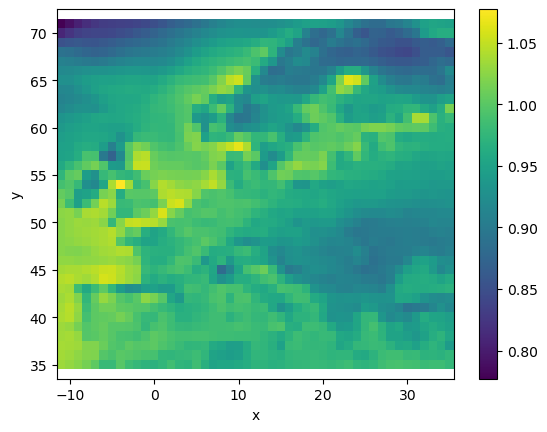

In [14]:
# Corr_factors_PV_EC_Earth3_no_indicator_matrix.plot()

# CALCULATING CORRECTION FACTORS ALSO FOR OCEAN

In [15]:
# # Corr_factors_wind_era5: Correction factors for ERA5 based on GWA - ALSO FOR OCEAN
# Corr_factors_wind_era5 = xr.open_dataarray("E:\\Master's\Corr_factors_wind_era5.nc")

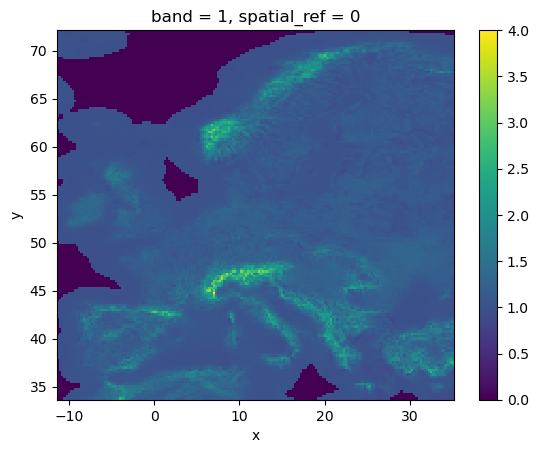

In [16]:
# Corr_factors_wind_era5.plot()

In [8]:
# # Calculating wind speed at 90m for GWA-corrected ERA5 (as a timeseries for every cutout)

# corr_factor_filename = f'Corr_factors_wind_era5'
# # Setting correction factors outside area of interest to 1: 
# locals()[corr_factor_filename] = locals()[corr_factor_filename].where(locals()[corr_factor_filename] > 0, 1);

# for i in range(15,23):
#     cutout_name = f'Europe_era5_{i}'
#     # Calculating wind speed at hub height: 
#     from_height = 100;
#     from_name = "wnd{h:0d}m".format(h=int(from_height));
#     # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#     to_height = 90
#     to_name = "wnd{h:0d}m".format(h=int(to_height));
#     to_cutout_name = f'GWA_corrected_{cutout_name}_{to_name}'
#     locals()[cutout_name].data['wnd100m'] = locals()[cutout_name].data['wnd100m']*locals()[corr_factor_filename]        # Correcting ERA5 wind100m using GWA 
#     ds = locals()[cutout_name].data

#     locals()[to_cutout_name] = ds[from_name] * (
#                 np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"])
#             )
#     locals()[to_cutout_name].attrs.update({"long name": "Extrapolated {ht} m wind speed using logarithmic "
#                         "method with roughness and {hf} m wind speed"
#                         "".format(ht=to_height, hf=from_height),
#                         "units": "m s**-1"})
    
# cutout_name = f'GWA_corrected_Europe_era5_15_wnd90m'
# GWA_corrected_era5_wnd90m = xr.DataArray(locals()[cutout_name])
# for i in range(16,23):
#     cutout_name = f'GWA_corrected_Europe_era5_{i}_wnd90m'
#     GWA_corrected_era5_wnd90m = xr.concat([GWA_corrected_era5_wnd90m,locals()[cutout_name]],dim="time")
# # ERA5 at CMIP6 resolution:
# GWA_corrected_era5_wnd90m_coarse = atlite.gis.regrid(GWA_corrected_era5_wnd90m,Europe_EC_Earth3_ssp585_15_22.data.x, Europe_EC_Earth3_ssp585_15_22.data.y,resampling=rasterio.warp.Resampling.average)

In [10]:
# Europe_era5_15_22_wnd90m_3hr_uncorrected = xr.open_dataarray(f"E:\\Master's\Spatial_correlation_BOC_corrected\era5\Europe_era5_15_22_wnd90m_3hr_uncorrected.nc")

## Calculating corrected timeseries for wnd90m and solar BOC

In [23]:
# # Calculating CMIP6 cutouts with wnd90m that is corrected by GWA-corrected ERA5 (filenames: "Corrected_Europe_{CMIP6_model}_{ssp_variant}_15_22_wnd90m")
# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_15_22'
#     if cutout_name in locals():
#         # Calculating wind speed at hub height (as a timeseries for every cutout)
#         from_height = 10;
#         from_name = "wnd{h:0d}m".format(h=int(from_height));
#         # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#         to_height = 90
#         to_name = "wnd{h:0d}m".format(h=int(to_height));
#         to_cutout_name = f'{cutout_name}_{to_name}'
#         to_cutout_name_corrected = f'Corrected_{to_cutout_name}'
#         corr_factor_filename = f'Corrected_era5_Corr_factors_wind_{CMIP6_model}_no_indicator_matrix'
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]*locals()[corr_factor_filename]
        
#         print(f'"{to_cutout_name_corrected}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_MIROC6_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_AWI_CM_1_1_MR_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_IPSL_CM6A_LR_ssp585_15_22_wnd90m" created. 
"Corrected_Europe_EC_Earth3_Veg_ssp585_15_22_wnd90m" created. 


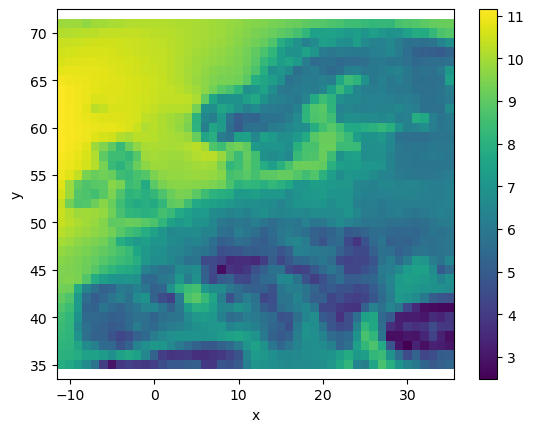

In [25]:
# ## HOW THE MAP SHOULD LOOK LIKE WITH GWA CORRECTED ERA5 CORRECTED WND90M
# Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m.mean(dim=["time"],keep_attrs=True).plot()

In [27]:
# # Calculating CMIP6 cutouts with influx that is corrected by ERA5 (filenames: "Corrected_Europe_{CMIP6_model}_{ssp_variant}_15_22_influx")
# for CMIP6_model in CMIP6_models_solar:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_15_22'
#     if cutout_name in locals():
#         to_name = "influx"
#         to_cutout_name = f'{cutout_name}_{to_name}'
#         to_cutout_name_corrected = f'Corrected_{to_cutout_name}'
#         corr_factor_filename = f'Corr_factors_PV_{CMIP6_model}_no_indicator_matrix'
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]*locals()[corr_factor_filename]
        
#         print(f'"{to_cutout_name_corrected}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Corrected_Europe_EC_Earth3_ssp585_15_22_influx" created. 
"Corrected_Europe_MIROC6_ssp585_15_22_influx" created. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx" created. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx" created. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx" created. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_influx" created. 
"Corrected_Europe_AWI_CM_1_1_MR_ssp585_15_22_influx" created. 
"Corrected_Europe_IPSL_CM6A_LR_ssp585_15_22_influx" created. 
"Corrected_Europe_ACCESS_CM2_ssp585_15_22_influx" created. 


In [11]:
# Corrected_Europe_EC_Earth3_ssp585_15_22_influx = Corrected_Europe_EC_Earth3_ssp585_15_22_influx.load()

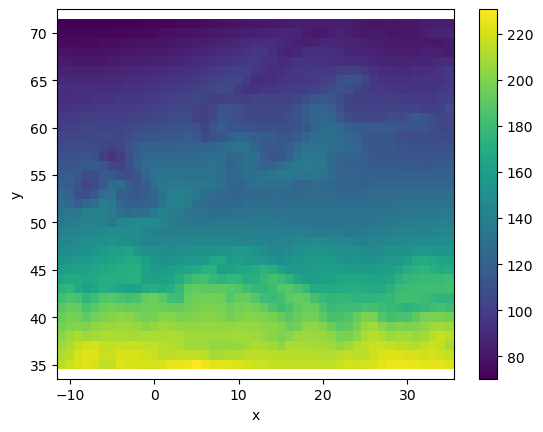

In [29]:
# ## HOW THE MAP SHOULD LOOK LIKE WITH ERA5 CORRECTED INFLUX
# Corrected_Europe_EC_Earth3_ssp585_15_22_influx.mean(dim=["time"],keep_attrs=True).plot()

## Loading the data (.load()) and saving as .nc file

### wnd90m

In [30]:
# # Creating wind timeseries for models
# # CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR','MPI-ESM1-2-HR','HadGEM3-GC31-LL','HadGEM3-GC31-MM','AWI-CM-1-1-MR','EC-Earth3-Veg']
# CMIP6_models = CMIP6_models_wind
# ssp_variants = ['ssp585']
# variable = 'wnd90m'

# date_format = "%Y-%m-%d"
# # Define cutout time duration: 
# start_date = "2015-01-01"
# end_date = "2022-12-31"

# yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
# yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

# for i in CMIP6_models:
#     i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
#     for j in ssp_variants:
#         variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
#         savepath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\{variablename}"
#         locals()[variablename] = locals()[variablename].load()
#         locals()[variablename].to_netcdf(path=savepath)
#         print(f'"{variablename}" saved to path: {savepath}. ')

"Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m. 
"Corrected_Europe_MIROC6_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_wnd90m. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_

In [31]:
# heptest = xr.open_dataarray(f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m")

In [32]:
# heptest = heptest.load()

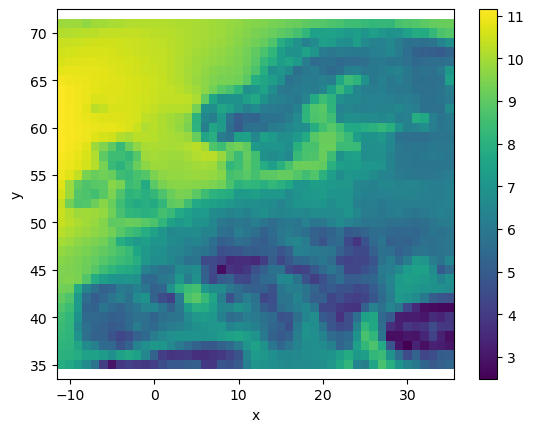

In [33]:
# heptest.mean(dim=["time"],keep_attrs=True).plot()

#### Influx

In [34]:
# # Creating wind timeseries for models
# # CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR','MPI-ESM1-2-HR','HadGEM3-GC31-LL','HadGEM3-GC31-MM','AWI-CM-1-1-MR','EC-Earth3-Veg']
# CMIP6_models = CMIP6_models_solar
# ssp_variants = ['ssp585']
# variable = 'influx'

# date_format = "%Y-%m-%d"
# # Define cutout time duration: 
# start_date = "2015-01-01"
# end_date = "2022-12-31"

# yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
# yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

# for i in CMIP6_models:
#     i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
#     for j in ssp_variants:
#         variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
#         savepath = f"E:\\Master's\Corrected influx for CMIP6 models\BOC\{variablename}"
#         locals()[variablename] = locals()[variablename].load()
#         locals()[variablename].to_netcdf(path=savepath)
#         print(f'"{variablename}" saved to path: {savepath}. ')

"Corrected_Europe_EC_Earth3_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_influx. 
"Corrected_Europe_MIROC6_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_influx. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_influx" saved to path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_

In [35]:
# heptest2 = xr.open_dataarray(f"E:\\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_influx")
# heptest2 = heptest2.load()

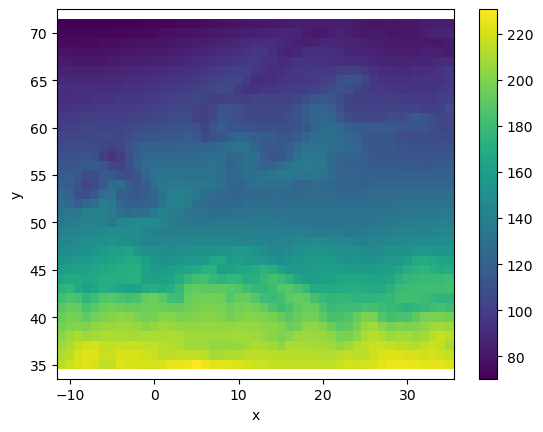

In [36]:
# heptest2.mean(dim=["time"],keep_attrs=True).plot()

In [85]:
# ### LOADING ERA5 CORRECTED BY ERA5
# GWA_corrected_era5_wnd90m_coarse = GWA_corrected_era5_wnd90m_coarse.load()

Saving the .load() data as .nc file in a hope to save time.

In [89]:
# variablename = f'Corrected_Europe_GWA_corrected_era5_{yy_start}_{yy_end}_{variable}'
# savepath = f"E:\\Master's\Spatial_correlation_BOC_corrected\wnd90m\{variablename}"
# print(f'"{variablename}" saved to path: {savepath}. ')
# GWA_corrected_era5_wnd90m_coarse.to_netcdf(path=savepath)

"Corrected_Europe_GWA_corrected_era5_15_22_wnd90m" saved to path: E:\Master's\Spatial_correlation_BOC_corrected\wnd90m\Corrected_Europe_GWA_corrected_era5_15_22_wnd90m. 


### Solar

In [187]:
# ### LOADING ERA5 INFLUX
# era5_influx_coarse = era5_influx_coarse.load()

In [192]:
# variablename = f'Corrected_Europe_era5_{yy_start}_{yy_end}_{variable}'
# savepath = f"E:\\Master's\Spatial_correlation_BOC_corrected\influx\{variablename}"
# print(f'"{variablename}" saved to path: {savepath}. ')
# era5_influx_coarse.to_netcdf(path=savepath)

"Corrected_Europe_era5_15_22_influx" saved to path: E:\Master's\Spatial_correlation_BOC_corrected\influx\Corrected_Europe_era5_15_22_influx. 


# Making corrected time series for EOC
Making corrected wnd90m and influx time series for EOC - Will then use these to make the spatial and autocorrelation plots in the  "Spatio-temporal correlations - only plots"

In [37]:
# # All CMIP6 models: 
# CMIP6_models = ['EC-Earth3', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR','HadGEM3-GC31-MM', 'HadGEM3-GC31-LL', 'AWI-CM-1-1-MR','IPSL-CM6A-LR','EC-Earth3-Veg','ACCESS-CM2']
# CMIP6_models_wind = ['EC-Earth3','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','EC-Earth3-Veg'] #wind
# CMIP6_models_solar = ['EC-Earth3', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','ACCESS-CM2']
# ssp_variants = ['ssp585']

In [38]:
# # Importing/creating  CMIP6 cutouts from external HDD
# # Models with all 4 ssp variants:
# CMIP6_models = CMIP6_models
# ssp_variants = ['ssp585']

# date_format = "%Y-%m-%d"
# # Define cutout time duration: 
# start_date = "2070-01-01"
# end_date = "2099-12-31"

# yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
# yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

# for i in CMIP6_models:
#     i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
#     for j in ssp_variants:
#         cutout_name = f'Europe_{i}_{j}_{yy_start}_{yy_end}'
#         filename = f'Europe_{i}_{j}_{yy_start}_{yy_end}.nc'
#         path = f"E://Master's/CMIP6_EOC/{filename}"
#         locals()[cutout_name] = atlite.Cutout(
#         path=path, module="cmip", bounds=bounds, time=slice(start_date, end_date),
#         dt='3H',dx=1, dy=1)

c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already 

## CORRECTING THE EOC WIND SPEEDS (USING THE Corrected_era5_Corr_factors_wind_{CMIP6_modell})

In [39]:
# # Getting wind speed at 90m from CMIP6 models - method 2
# ssp_variant = 'ssp585'

# # Defining roughness to extrapolate hub height wind speed:
# roughness = xr.open_dataset('roughness.nc')
# roughness = roughness.rename({'fsr':'roughness'})
# roughness = roughness.mean(dim='time')
# roughness = _rename_and_clean_coords(roughness)
# roughness.roughness.attrs['prepared_feature'] = 'wind'

# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         # Calculating wind speed at hub height (as a timeseries for every cutout)
#         from_height = 10;
#         from_name = "wnd{h:0d}m".format(h=int(from_height));
#         # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#         to_height = 90
#         to_name = "wnd{h:0d}m".format(h=int(to_height));
#         to_cutout_name = f'{cutout_name}_{to_name}'
        
#         # Adding roughness data (from ERA5) into the cutout:
#         da = roughness.roughness.interp_like(locals()[cutout_name].data['wnd10m'].isel(time=0))
#         locals()[cutout_name].data = locals()[cutout_name].data.assign(roughness=da)

#         ds = locals()[cutout_name].data
#         locals()[to_cutout_name] = ds[from_name] * (
#                     np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"]))
#         locals()[to_cutout_name].attrs.update({"long name": "Extrapolated {ht} m wind speed using logarithmic "
#                             "method with roughness and {hf} m wind speed"
#                             "".format(ht=to_height, hf=from_height),
#                             "units": "m s**-1"})

#         print(f'"{to_cutout_name}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Europe_EC_Earth3_ssp585_70_99_wnd90m" created. 
"Europe_MIROC6_ssp585_70_99_wnd90m" created. 
"Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m" created. 
"Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m" created. 
"Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m" created. 
"Europe_HadGEM3_GC31_LL_ssp585_70_99_wnd90m" created. 
"Europe_AWI_CM_1_1_MR_ssp585_70_99_wnd90m" created. 
"Europe_IPSL_CM6A_LR_ssp585_70_99_wnd90m" created. 
"Europe_EC_Earth3_Veg_ssp585_70_99_wnd90m" created. 


In [41]:
# # Loading CMIP6 cutouts with wnd90m that is corrected by GWA-corrected ERA5 (filenames: "Corrected_Europe_{CMIP6_model}_{ssp_variant}_15_22_wnd90m")
# for CMIP6_model in CMIP6_models_wind:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         # Calculating wind speed at hub height (as a timeseries for every cutout)
#         from_height = 10;
#         from_name = "wnd{h:0d}m".format(h=int(from_height));
#         # to_height = atlite.resource.get_windturbineconfig(turbine)['hub_height'];       # 90 m in current config
#         to_height = 90
#         to_name = "wnd{h:0d}m".format(h=int(to_height));
#         to_cutout_name = f'{cutout_name}_{to_name}'
#         to_cutout_name_corrected = f'Corrected_{to_cutout_name}'
#         corr_factor_filename = f'Corrected_era5_Corr_factors_wind_{CMIP6_model}_no_indicator_matrix'
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]*locals()[corr_factor_filename]
        
#         print(f'"{to_cutout_name_corrected}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_MIROC6_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_AWI_CM_1_1_MR_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_IPSL_CM6A_LR_ssp585_70_99_wnd90m" created. 
"Corrected_Europe_EC_Earth3_Veg_ssp585_70_99_wnd90m" created. 


#### Checking that the data look trustworthy before exporting all to .nc files - testing that EC-Earth3 looks the same as the ones without ocean
- IT DOES

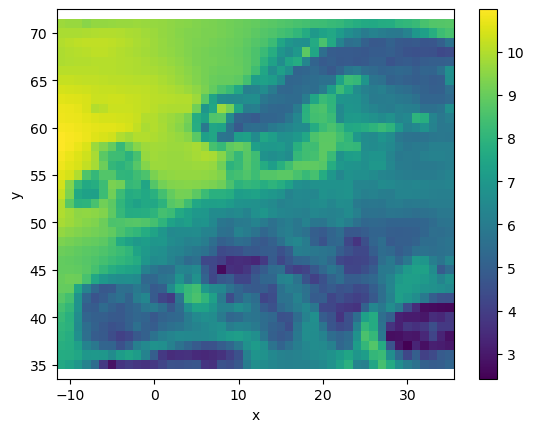

In [42]:
# Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m = Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m.load()

# ## WHAT THE MAP LOOKS LIKE WITH THE VALUES JUST CALCULATED
# Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m.mean(dim=["time"],keep_attrs=True).plot()

In [43]:
# # Saving as .nc files in the folder
# # CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR','MPI-ESM1-2-HR','HadGEM3-GC31-LL','HadGEM3-GC31-MM','AWI-CM-1-1-MR','EC-Earth3-Veg']
# CMIP6_models = CMIP6_models_wind
# ssp_variants = ['ssp585']
# variable = 'wnd90m'

# date_format = "%Y-%m-%d"
# # Define cutout time duration: 
# start_date = "2070-01-01"
# end_date = "2099-12-31"

# yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
# yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

# for i in CMIP6_models:
#     i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
#     for j in ssp_variants:
#         variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
#         # savepath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\EOC\{variablename}.nc"
#         savepath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\EOC\{variablename}"
#         # savepath = f"C:\\Users\Theag\OneDrive\Skrivebord\EOC\wnd90m\{variablename}.nc"
#         # savepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Semester 11\Master's\Thea\Thea's Jupyter Notebooks\Testing changes to Atlite\EOC_wnd90m\{variablename}.nc"
#         locals()[variablename] = locals()[variablename].load()
#         locals()[variablename].to_netcdf(path=savepath)
#         print(f'"{variablename}" saved to path: {savepath}. ')

"Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m. 
"Corrected_Europe_MIROC6_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_wnd90m. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_wnd90m" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_

## CORRECTING THE EOC INFLUX (USING THE Corr_factors_PV_{CMIP6_modell})

In [45]:
# # Getting influx data from CMIP6 models
# ssp_variant = 'ssp585'

# for CMIP6_model in CMIP6_models_solar:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         to_cutout_name = f'{cutout_name}_influx' 
#         ds = locals()[cutout_name].data
#         locals()[to_cutout_name] = locals()[cutout_name].data['influx']
#         # Calculating average influx for each cell for 8 years:
#         cutout_mean_name = f'{to_cutout_name}_mean'
#         locals()[cutout_mean_name] = locals()[to_cutout_name].mean(dim=["time"],keep_attrs=True)
#         print(f'{to_cutout_name} created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

Europe_EC_Earth3_ssp585_70_99_influx created. 
Europe_MIROC6_ssp585_70_99_influx created. 
Europe_MPI_ESM1_2_HR_ssp585_70_99_influx created. 
Europe_MPI_ESM1_2_LR_ssp585_70_99_influx created. 
Europe_HadGEM3_GC31_MM_ssp585_70_99_influx created. 
Europe_HadGEM3_GC31_LL_ssp585_70_99_influx created. 
Europe_AWI_CM_1_1_MR_ssp585_70_99_influx created. 
Europe_IPSL_CM6A_LR_ssp585_70_99_influx created. 
Europe_ACCESS_CM2_ssp585_70_99_influx created. 


In [46]:
# # Calculating influx that is corrected by ERA5 (filenames: "Corrected_Europe_{CMIP6_model}_{ssp_variant}_70_99_influx")
# for CMIP6_model in CMIP6_models_solar:
#     CMIP6_model = CMIP6_model.replace("-", "_")
#     cutout_name = f'Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
#     if cutout_name in locals():
#         to_name = "influx"
#         to_cutout_name = f'{cutout_name}_{to_name}'
#         to_cutout_name_corrected = f'Corrected_{to_cutout_name}'
#         corr_factor_filename = f'Corr_factors_PV_{CMIP6_model}_no_indicator_matrix'
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]
#         locals()[to_cutout_name_corrected] = locals()[to_cutout_name]*locals()[corr_factor_filename]
        
#         print(f'"{to_cutout_name_corrected}" created. ')
#     else: 
#         print(f'WARNING: Cutout {cutout_name} skipped. It does not exist or is not loaded. ')

"Corrected_Europe_EC_Earth3_ssp585_70_99_influx" created. 
"Corrected_Europe_MIROC6_ssp585_70_99_influx" created. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx" created. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx" created. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx" created. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_influx" created. 
"Corrected_Europe_AWI_CM_1_1_MR_ssp585_70_99_influx" created. 
"Corrected_Europe_IPSL_CM6A_LR_ssp585_70_99_influx" created. 
"Corrected_Europe_ACCESS_CM2_ssp585_70_99_influx" created. 


#### Checking that the data look trustworthy before exporting all to .nc files
It does 

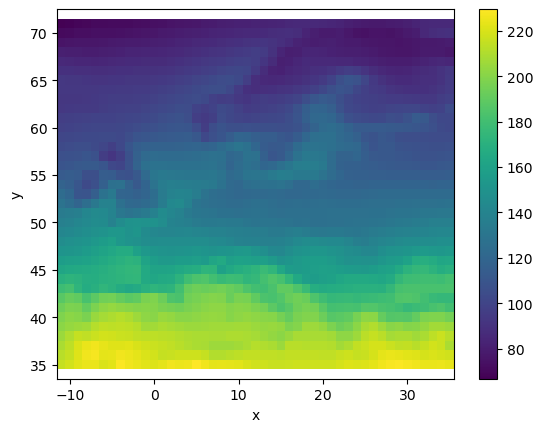

In [47]:
# Corrected_Europe_EC_Earth3_ssp585_70_99_influx = Corrected_Europe_EC_Earth3_ssp585_70_99_influx.load()

# ## WHAT THE MAP LOOKS LIKE WITH THE VALUES JUST CALCULATED
# Corrected_Europe_EC_Earth3_ssp585_70_99_influx.mean(dim=["time"],keep_attrs=True).plot()

In [52]:
# CMIP6_models = CMIP6_models_solar
# ssp_variants = ['ssp585']
# variable = 'influx'

# date_format = "%Y-%m-%d"
# # Define cutout time duration: 
# start_date = "2070-01-01"
# end_date = "2099-12-31"

# yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
# yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

# for i in CMIP6_models:
#     i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
#     for j in ssp_variants:
#         variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
#         savepath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\EOC\{variablename}"
#         locals()[variablename] = locals()[variablename].load()
#         locals()[variablename].to_netcdf(path=savepath)
#         print(f'"{variablename}" saved to path: {savepath}. ')

"Corrected_Europe_EC_Earth3_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_influx. 
"Corrected_Europe_MIROC6_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_influx. 
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx. 
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx. 
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx. 
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_influx" saved to path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_

# Retrieving the data which is saved as an .nc file. 

In [12]:
### corrected (by GWA) era5 for europe - at 90m, 3hr and coarse resolution - THIS IS CORRECT
savedpath = f"E:\\Master's\ERA5\wnd90m\Europe_era5_15_22_wnd90m_3hr_corrected.nc"
Europe_era5_15_22_wnd90m_3hr_corrected = xr.open_dataarray(savedpath)
Europe_era5_15_22_wnd90m_3hr_corrected = Europe_era5_15_22_wnd90m_3hr_corrected.load()

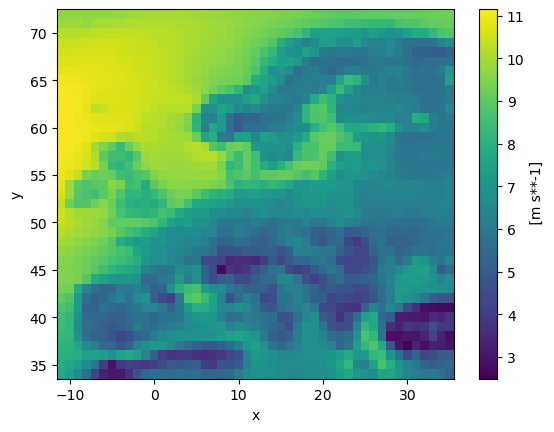

In [13]:
Europe_era5_15_22_wnd90m_3hr_corrected.mean(dim=["time"],keep_attrs=True).plot()

In [14]:
### LOADING ERA5 INFLUX (AT 3hourly VALUES!) - THIS ONE IS CORRECT!! 
savedpath = f"E:\\Master's\ERA5\influx\Europe_era5_15_22_influx_3hr.nc"
Europe_era5_15_22_influx_3hr = xr.open_dataset(savedpath)
Europe_era5_15_22_influx_3hr =Europe_era5_15_22_influx_3hr["__xarray_dataarray_variable__"].load()

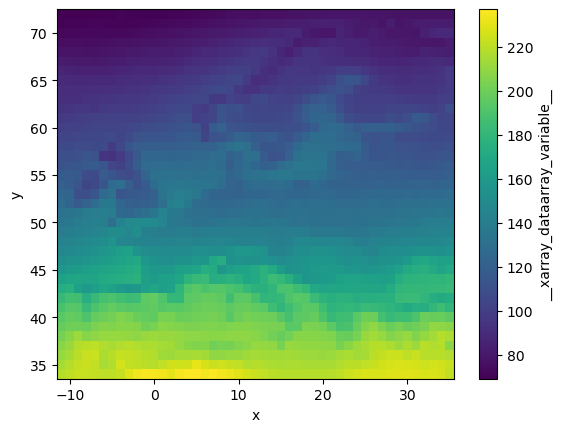

In [15]:
Europe_era5_15_22_influx_3hr.mean(dim=["time"],keep_attrs=True).plot()

In [16]:
########## Retrieving the BOC corrected WND90m #################
CMIP6_models = CMIP6_models_wind
ssp_variants = ['ssp585']
variable = 'wnd90m'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MIROC6_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Co

In [17]:
########## SOLAR #################
CMIP6_models = CMIP6_models_solar
ssp_variants = ['ssp585']
variable = 'influx'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected influx for CMIP6 models\BOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_influx.nc
"Corrected_Europe_MIROC6_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_influx.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Co

### Retrieving BOC wnd90m for EC-Earth3 with method 3

In [18]:
variablename = f'Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix'
savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\{variablename}.nc"
print(f'"{variablename}" retrieved from path: {savedpath}')
locals()[variablename] = xr.open_dataset(savedpath)
locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix.nc


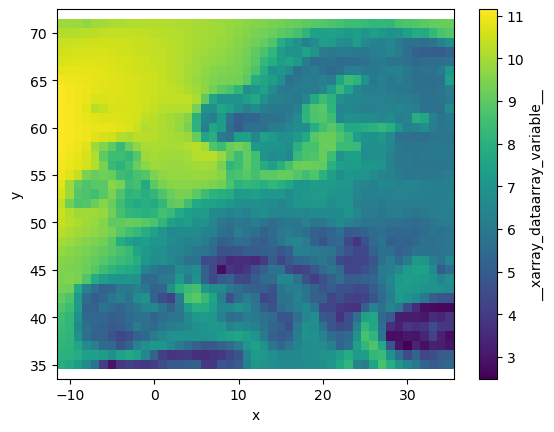

In [19]:
Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix.mean(dim="time",keep_attrs=True).plot()


### Retrieving EOC data

In [20]:
########## WND90m EOC #################
CMIP6_models = CMIP6_models_wind
ssp_variants = ['ssp585']
variable = 'wnd90m'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2070-01-01"
end_date = "2099-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\EOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MIROC6_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Co

In [21]:
########## SOLAR EOC #################
CMIP6_models = CMIP6_models_solar
ssp_variants = ['ssp585']
variable = 'influx'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2070-01-01"
end_date = "2099-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected influx for CMIP6 models\EOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_influx.nc
"Corrected_Europe_MIROC6_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_influx.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Co

# Spatial correlation function
Here the function for doing spatial correlation analysis is defined

In [22]:
def spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs,saveplot=None,make_plot=True):
    if np.any(data.isnull())==True: 
        # data = data.where(data.isnull()==False,0.0)
        data = data.dropna(dim="x",how="all").dropna(dim="y",how="all")
    
    # cell_coords = [grid_coords[1] - data[0,0,0].y.values,grid_coords[0] - data[0,0,0].x.values]
    cell_coords = [int(grid_coords[1] - data[0,0,0].y.values),int(grid_coords[0] - data[0,0,0].x.values)]
        
    if CMIP6_model == 'MPI_ESM1_2_HR' or CMIP6_model == 'EC_Earth3 _ method 3' and variable =='wnd90m':
        cell1 = data[cell_coords[0],cell_coords[1],:]
        range_i = range(data.shape[0])
        range_j = range(data.shape[1])
        corr_coeffs = xr.zeros_like(data[:,:,1])
        dist = xr.zeros_like(data[:,:,1])
    else: 
        cell1 = data[:,cell_coords[0],cell_coords[1]]
        range_i = range(data.shape[1])
        range_j = range(data.shape[2])
        corr_coeffs = xr.zeros_like(data[1,:,:])
        dist = xr.zeros_like(data[1,:,:])
 
    for i in range_i:
        # for j in range(data.shape[2]):
        for j in range_j:
            if CMIP6_model == 'MPI_ESM1_2_HR' or CMIP6_model == 'EC_Earth3 _ method 3' and variable =='wnd90m': 
                cell2 = data[i,j,:]
            else: 
                print('notyup2')
                cell2 = data[:,i,j]
            
            corr = xr.corr(cell1,cell2,dim="time").values
            corr_coeffs[i,j] = corr
            dist[i,j] = np.sqrt(np.square(cell_coords[0]-i)+np.square(cell_coords[1]-j))*dx

    # dis = np.sort(dist.to_numpy().flatten())
    dis = dist.to_numpy().flatten()
    cor_theo = xr.DataArray(coords=(range(len(CLs)),range(len(dis))))
    i=0
    RMSE=[]
    for CL in CLs: 
        cor_theo[i] = [np.exp(-(1/CL)*d) for d in dis]
        if np.any(cor_theo[i].isnull())==True: print('cor theo isnull') 
        MSE = mean_squared_error(corr_coeffs.to_numpy().flatten(),cor_theo[i])
        # MSE = mean_squared_error(np.sort(corr_coeffs.to_numpy().flatten()),cor_theo[i])
        RMSE.append(round(math.sqrt(MSE),7))
        i = i+1

    # saving the min values and sorting them for a more practical output:
    min_RMSE_index = RMSE.index(min(RMSE))
    cor_theo = cor_theo[min_RMSE_index].sortby(cor_theo[min_RMSE_index],ascending=False).values
    dis = np.sort(dis)

    if variable == "influx": plotcolor = 'gold'
    else: plotcolor = '#1f77b4'

    if make_plot ==True:
        plt.scatter(dist,corr_coeffs,s = 2,color=plotcolor,alpha=0.6)
        plt.plot(dis,cor_theo,'black',linewidth=2)
        plt.xlabel('Distance [km]')
        plt.ylabel("Pearson's correlation coefficient")
        plt.title(f"Spatial correlation, 20{yy_start}-20{yy_end} \n from gridpoint [{grid_coords[0]},{grid_coords[1]}]")
        plt.legend([f'{variable} - {CMIP6_model.replace("_","-")} - {ssp_variant}',f'Exponential fit, CL = {CLs[min_RMSE_index]} km, RMSE = {round(RMSE[min_RMSE_index],3)}'])
        plt.tight_layout
    
    if saveplot != None:
        filepath = 'Plots_spatial_correlation/'f'Spatial_correlation_{CMIP6_model}_{ssp_variant}_grid_x{grid_coords[0]}_y{grid_coords[1]}'
        plt.savefig(filepath)
        print('Plot saved to',filepath)
        
    return CLs[min_RMSE_index], RMSE[min_RMSE_index], cor_theo,dis 

## Spatial correlation result plots - wnd90m
Here, the resulting plot from a spatial correlation for a single model is shown.

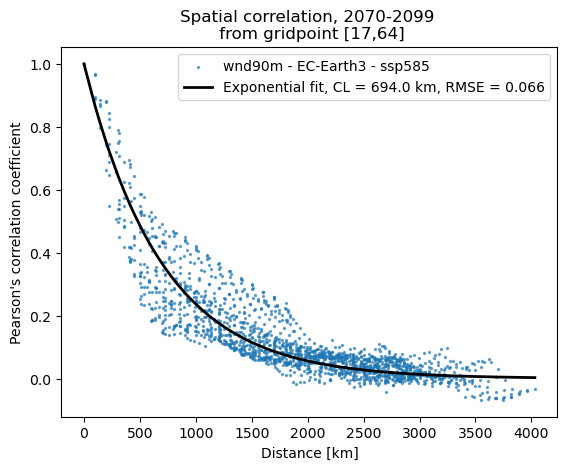

In [15]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 70
yy_end = 99
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]
CLs = np.linspace(100,2000,1901)    #wind

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

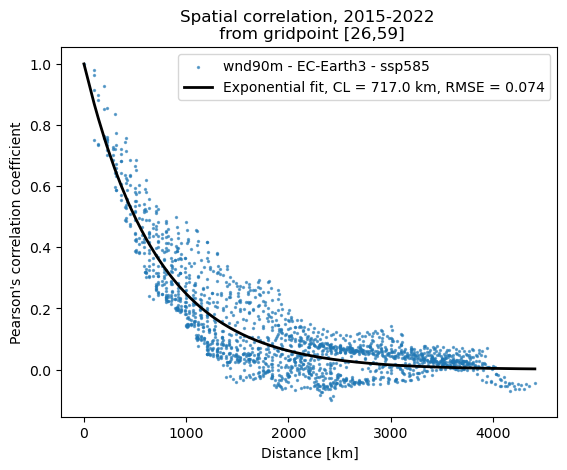

In [136]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 15
yy_end = 22
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [26,59]
CLs = np.linspace(100,2000,1901)    #wind

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

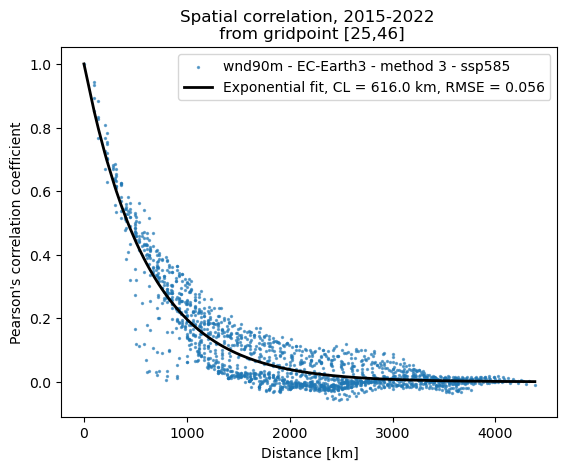

In [20]:
########### EC EARTH3 - METHOD 3 ######
### INPUTS ####
CMIP6_model = 'EC-Earth3 - method 3'
yy_start = 15
yy_end = 22
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [25,46]
CLs = np.linspace(100,2000,1901)    #wind

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
# data = locals()[f'{cutout_name}_{variable}']
data = Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

In [64]:
#### SAVING DIS, COR_THEO, CL and RMSE TO .NC - This .nc file is used in the code "Spatio-temporal correlations - only plots"####

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

locals()[f"dis_{variable}_EC_Earth3_method3_{grid_info}"]  = pd.DataFrame(dis,columns = ["dis"])
locals()[f"cor_theo_{variable}_EC_Earth3_method3_{grid_info}"]  = pd.DataFrame(cor_theo,columns = ["cor_theo"])
cor_theo_xarray_EC_Earth3_method3 = locals()[f"cor_theo_{variable}_EC_Earth3_method3_{grid_info}"].to_xarray()
dis_xarray_EC_Earth3_method3 = locals()[f"dis_{variable}_EC_Earth3_method3_{grid_info}"].to_xarray()

path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\"
path_cor_theo_EC_Earth3_method3 = f"{path}\cor_theo\cor_theo_{variable}_EC_Earth3_method3_{grid_info}.nc"
path_dis_EC_Earth3_method3 = f"{path}\dis\dis_{variable}_EC_Earth3_method3_{grid_info}.nc"
cor_theo_xarray_EC_Earth3_method3.to_netcdf(path=path_cor_theo_EC_Earth3_method3)
dis_xarray_EC_Earth3_method3.to_netcdf(path=path_dis_EC_Earth3_method3)
print(path_dis_EC_Earth3_method3)

E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\dis\dis_wnd90m_EC_Earth3_method3_xneg4_y40.nc


In [65]:
## Saving the CL and RMSE as a dataframe.
locals()[f"CL_RMSE_{variable}_EC_Earth3_method3_{grid_info}"]=pd.DataFrame(np.zeros([1,2]),columns=['CL','RMSE'],index=["EC_Earth3_method3"])
locals()[f"CL_RMSE_{variable}_EC_Earth3_method3_{grid_info}"]["CL"] = CL
locals()[f"CL_RMSE_{variable}_EC_Earth3_method3_{grid_info}"]["RMSE"] = RMSE

path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_EC_Earth3_method3_{variable}_{grid_info}_BOC.nc"
CL_RMSE_xarray = locals()[f"CL_RMSE_{variable}_EC_Earth3_method3_{grid_info}"].to_xarray()
CL_RMSE_xarray.to_netcdf(path=path)

[4103.65690574 4036.08721412 3969.88664826 ... 1788.854382   1878.82942281
 1969.77156036]


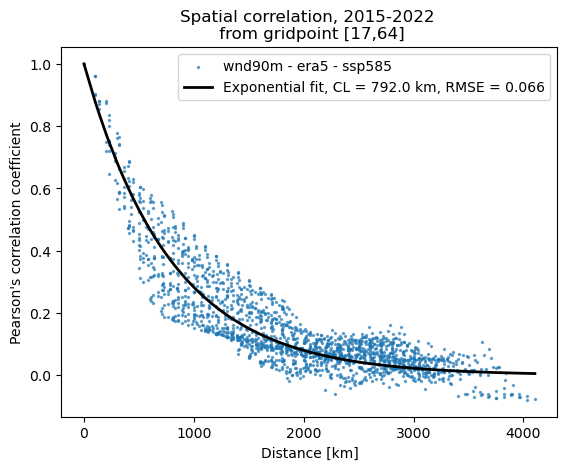

In [90]:
### PLOTTING THE SPATIAL CORRELATION FOR ERA5 ####
### INPUTS ####
CMIP6_model = 'era5'
yy_start = 15
yy_end = 22
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]
CLs = np.linspace(100,2000,1901)    #wind

CMIP6_model = CMIP6_model.replace("-","_")
# cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
# data = locals()[f'{cutout_name}_{variable}']
data = GWA_corrected_era5_wnd90m_coarse

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

## Spatial correlation result plots - influx
Here, the resulting plot from a spatial correlation for a single model is shown.

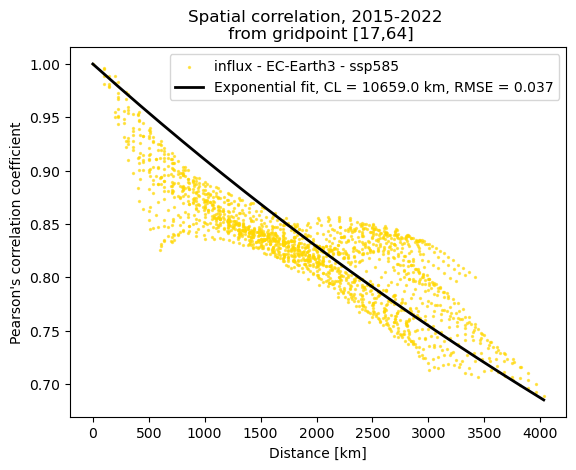

In [56]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 15
yy_end = 22
variable = "influx"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]
CLs = np.linspace(1000,15000,14001)           #solar


CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

# Comparing CL's for ERA5 and different models - BOC - saving the values as .nc files to use later for plotting
This is only doing calculations and saving dis,cor_theo, CL's and RMSE's for the models - it is saved in the Spatial Correlation for corrected CMIP6 models folder, which has the values for calculations done on corrected ERA5 and CMIP6 model outputs. 

In [133]:
grid_coords = [-1,52]
variable = "wnd90m"
# variable = "influx"

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    CLs = np.linspace(100,2000,1901)    #wind
else: 
    CMIP6_models = CMIP6_models_solar
    CLs = np.linspace(1000,20000,19001)           #solar

ssp_variant = 'ssp585'
yy_start = 15
yy_end = 22
dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

grid_info

'xneg1_y52'

In [86]:
### Getting CL, RMSE, cor_theo and dis for each CMIP6 model####
locals()[f"CL_RMSE_{variable}_{grid_info}"]=pd.DataFrame(np.zeros([len(CMIP6_models),2]),columns=['CL','RMSE'],index=CMIP6_models)
i = 0

for CMIP6_model in CMIP6_models:
    model = CMIP6_model
    CMIP6_model = CMIP6_model.replace("-","_")
    print(CMIP6_model)
    cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
    data = locals()[f'{cutout_name}_{variable}']

    CL, RMSE, cor_theo, dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs,make_plot = 'No')
    locals()[f"CL_RMSE_{variable}_{grid_info}"]["CL"].loc[model] = int(CL)
    locals()[f"CL_RMSE_{variable}_{grid_info}"]["RMSE"].loc[model] = round(RMSE,3)
    locals()[f"dis_{variable}_{CMIP6_model}_{grid_info}"]  = pd.DataFrame(dis,columns = ["dis"])
    locals()[f"cor_theo_{variable}_{CMIP6_model}_{grid_info}"] = pd.DataFrame(cor_theo,columns = ["cor_theo"])
    i = i + 1

EC_Earth3
MIROC6
MPI_ESM1_2_HR
MPI_ESM1_2_LR
HadGEM3_GC31_MM
HadGEM3_GC31_LL
AWI_CM_1_1_MR
IPSL_CM6A_LR
EC_Earth3_Veg


In [87]:
#### Getting dis, cor_theo, CL and RMSE for era5 and saving as .nc file ####

if variable == 'wnd90m': 
    era5_data = Europe_era5_15_22_wnd90m_3hr_corrected 
if variable == 'influx': 
    era5_data = Europe_era5_15_22_influx_3hr

locals()[f"CL_RMSE_{variable}_era5_{grid_info}"]=pd.DataFrame(np.zeros([1,2]),columns=['CL','RMSE'],index=["era5"])
locals()[f"CL_RMSE_{variable}_era5_{grid_info}"]["CL"], locals()[f"CL_RMSE_{variable}_era5_{grid_info}"]["RMSE"],cor_theo_era5,dis_era5 = spatial_correlation(era5_data,
                                                               'era5','',dx,yy_start,yy_end,variable,grid_coords,CLs,make_plot = 'No')

locals()[f"dis_{variable}_era5_{grid_info}"]  = pd.DataFrame(dis_era5,columns = ["dis_era5"])
locals()[f"cor_theo_{variable}_era5_{grid_info}"]  = pd.DataFrame(cor_theo_era5,columns = ["cor_theo_era5"])
cor_theo_xarray_era5 = locals()[f"cor_theo_{variable}_era5_{grid_info}"].to_xarray()
dis_xarray_era5 = locals()[f"dis_{variable}_era5_{grid_info}"].to_xarray()

path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\"
path_cor_theo_era5 = f"{path}\cor_theo\cor_theo_{variable}_era5_{grid_info}.nc"
path_dis_era5 = f"{path}\dis\dis_{variable}_era5_{grid_info}.nc"
cor_theo_xarray_era5.to_netcdf(path=path_cor_theo_era5)
dis_xarray_era5.to_netcdf(path=path_dis_era5)
print(path_dis_era5)

## adding CL and RMSE for era5 to the dataframe with these values for CMIP6 models ###
locals()[f"CL_RMSE_{variable}_{grid_info}"] = pd.concat([locals()[f"CL_RMSE_{variable}_{grid_info}"],locals()[f"CL_RMSE_{variable}_era5_{grid_info}"]])
locals()[f"CL_RMSE_{variable}_{grid_info}"].drop_duplicates()

E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\dis\dis_wnd90m_era5_x26_y59.nc


,CL,RMSE
EC-Earth3,717.0,0.074000
MIROC6,1791.0,0.107000
MPI-ESM1-2-HR,1040.0,0.095000
MPI-ESM1-2-LR,899.0,0.083000
HadGEM3-GC31-MM,760.0,0.076000
HadGEM3-GC31-LL,733.0,0.085000
AWI-CM-1-1-MR,1002.0,0.096000
IPSL-CM6A-LR,905.0,0.082000
EC-Earth3-Veg,703.0,0.069000
era5,831.0,0.091732


In [88]:
## Saving as .nc files - want the plots to just use the .nc files, so it never needs to run (unless choosing a new gridpoint)
path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_{variable}_{grid_info}.nc"
CL_RMSE_xarray = locals()[f"CL_RMSE_{variable}_{grid_info}"].to_xarray()
CL_RMSE_xarray.to_netcdf(path=path)

## saving the dis and cor_theo separatly for each CMIP6 model.
# path = f"E://Master's/Spatial Correlation corrected CMIP6 models/BOC/"
path = f"C://Users/Theag/OneDrive/Skrivebord/BOC_spatial/"
for CMIP6_model in CMIP6_models:
    model = CMIP6_model
    CMIP6_model = CMIP6_model.replace("-","_")
    
    path_cor_theo = f"{path}\cor_theo\cor_theo_{variable}_{CMIP6_model}_{grid_info}.nc"
    cor_theo_name = f"cor_theo_{variable}_{CMIP6_model}_{grid_info}"
    cor_theo_xarray = locals()[cor_theo_name].to_xarray()
    cor_theo_xarray.to_netcdf(path=path_cor_theo)
    
    path_dis = f"{path}\dis\dis_{variable}_{CMIP6_model}_{grid_info}.nc"
    dis_name = f"dis_{variable}_{CMIP6_model}_{grid_info}"
    dis_xarray = locals()[dis_name].to_xarray()
    dis_xarray.to_netcdf(path=path_dis)    

# Comparing CL's for ERA5 and different models - EOC - saving the values as .nc files to use later for plotting
This is only doing calculations and saving dis,cor_theo, CL's and RMSE's for the models - it is saved in the Spatial Correlation for corrected CMIP6 models folder, which has the values for calculations done on corrected ERA5 and CMIP6 model outputs. 

In [146]:
grid_coords = [-4,40]
variable = "wnd90m"
# variable = "influx"

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    CLs = np.linspace(100,2000,1901)    #wind
else: 
    CMIP6_models = CMIP6_models_solar
    CLs = np.linspace(1000,20000,19001)           #solar

ssp_variant = 'ssp585'
yy_start = 70
yy_end = 99
dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

grid_info

'xneg4_y40'

In [147]:
### Getting CL, RMSE, cor_theo and dis for each CMIP6 model####
locals()[f"CL_RMSE_{variable}_{grid_info}"]=pd.DataFrame(np.zeros([len(CMIP6_models),2]),columns=['CL','RMSE'],index=CMIP6_models)
i = 0

for CMIP6_model in CMIP6_models:
    model = CMIP6_model
    CMIP6_model = CMIP6_model.replace("-","_")
    print(CMIP6_model)
    cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
    data = locals()[f'{cutout_name}_{variable}']

    CL, RMSE, cor_theo, dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs,make_plot = 'No')
    locals()[f"CL_RMSE_{variable}_{grid_info}"]["CL"].loc[model] = int(CL)
    locals()[f"CL_RMSE_{variable}_{grid_info}"]["RMSE"].loc[model] = round(RMSE,3)
    locals()[f"dis_{variable}_{CMIP6_model}_{grid_info}"]  = pd.DataFrame(dis,columns = ["dis"])
    locals()[f"cor_theo_{variable}_{CMIP6_model}_{grid_info}"] = pd.DataFrame(cor_theo,columns = ["cor_theo"])
    i = i + 1

EC_Earth3
MIROC6
MPI_ESM1_2_HR
MPI_ESM1_2_LR
HadGEM3_GC31_MM
HadGEM3_GC31_LL
AWI_CM_1_1_MR
IPSL_CM6A_LR
EC_Earth3_Veg


In [148]:
locals()[f"CL_RMSE_{variable}_{grid_info}"]

,CL,RMSE
EC-Earth3,600.0,0.059
MIROC6,576.0,0.058
MPI-ESM1-2-HR,686.0,0.069
MPI-ESM1-2-LR,682.0,0.085
HadGEM3-GC31-MM,554.0,0.109
HadGEM3-GC31-LL,564.0,0.117
AWI-CM-1-1-MR,681.0,0.079
IPSL-CM6A-LR,1191.0,0.126
EC-Earth3-Veg,588.0,0.061


In [149]:
## Saving as .nc files - want the plots to just use the .nc files, so it never needs to run (unless choosing a new gridpoint)
path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\EOC\CL_RMSE\CL_RMSE_{variable}_{grid_info}_EOC.nc"
CL_RMSE_xarray = locals()[f"CL_RMSE_{variable}_{grid_info}"].to_xarray()
CL_RMSE_xarray.to_netcdf(path=path)

## saving the dis and cor_theo separatly for each CMIP6 model.
# path = f"E://Master's/Spatial Correlation corrected CMIP6 models/EOC/"
path = f"C://Users/Theag/OneDrive/Skrivebord/EOC_spatial/"
for CMIP6_model in CMIP6_models:
    model = CMIP6_model
    CMIP6_model = CMIP6_model.replace("-","_")
    
    path_cor_theo = f"{path}\cor_theo\cor_theo_{variable}_{CMIP6_model}_{grid_info}_EOC.nc"
    cor_theo_name = f"cor_theo_{variable}_{CMIP6_model}_{grid_info}"
    cor_theo_xarray = locals()[cor_theo_name].to_xarray()
    cor_theo_xarray.to_netcdf(path=path_cor_theo)
    
    path_dis = f"{path}\dis\dis_{variable}_{CMIP6_model}_{grid_info}_EOC.nc"
    dis_name = f"dis_{variable}_{CMIP6_model}_{grid_info}"
    dis_xarray = locals()[dis_name].to_xarray()
    dis_xarray.to_netcdf(path=path_dis)    


The created .nc files are used in the "Spatio-temporal correlations - only plots" notebook. 